# 1) Make Training Data
Key values:
- 500 000 random points
- Scaled inputs and outputs
- Batch size = 200
- Learning rate = 0.01
- Epochs = 150 (early stopping applied)
- Early stopping patience = 10 epochs

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Set output function (y)
def y_func(x1, x2):
    y = x1**2 + 0.1*(x2**4 - 100) - 5
    return y

# Generate random training inputs
np.random.seed(0)
x1_min, x1_max = -5, 5
x2_min, x2_max = -5, 5
x1 = np.random.uniform(x1_min, x1_max, 500000)
x2 = np.random.uniform(x2_min, x2_max, 500000)

# Standardize x1 and x2 data
x1_standardized = (x1 - np.mean(x1)) / np.std(x1)
x2_standardized = (x2 - np.mean(x2)) / np.std(x2)

# Calculate mean and std of training input data
mean_x1, std_x1 = np.mean(x1), np.std(x1)
mean_x2, std_x2 = np.mean(x2), np.std(x2)

# Compute output training data
y = y_func(x1, x2)

# Scale outputs between 0.2 and 0.8 for linear range of sigmoid activation function
y_min, y_max = y.min(), y.max()
y_scld = (y - y_min) / (y_max - y_min) * 0.6 + 0.2

# Combine input data into a single array as Pytorch tensor
X = np.vstack((x1_standardized, x2_standardized)).T
X = torch.tensor(X, dtype=torch.float32)

# Convert output training data into Pytorch tensor
y_scld = torch.tensor(y_scld, dtype=torch.float32).view(-1, 1)


# 2) Create and train neural network

In [5]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import copy

# Define neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 80)  # Input layer to hidden layer
        self.layer2 = nn.Linear(80, 80) # Hidden layer to hidden layer
        self.layer3 = nn.Linear(80, 80)  # Hidden layer to hidden layer
        self.layer4 = nn.Linear(80, 1)  # Hidden layer to output layer
        # self.relu = nn.ReLU()           # ReLU activation

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.layer4(x))
        return x

# Initialize the model
model = NeuralNetwork()

# Create data set and data loader to use batches
dataset = TensorDataset(X, y_scld)
dataloader = DataLoader(dataset, batch_size=300, shuffle=True)

# Define loss function and optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
best_loss = float('inf')
patience = 10
patience_left = patience

# Train model
num_epochs = 150
for epoch in range(num_epochs):
    for x_batch, y_batch in dataloader:
        # Evaluate model
        outputs = model(x_batch)
        # Calculate loss
        loss = loss_func(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Early stopping criteria
    if loss <= best_loss:
        best_loss = loss
        patience_left = patience
        best_model_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch
    else:
        patience_left -= 1
        if patience_left == 0:
            break

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

# Use the best weights in the model
model.load_state_dict(best_model_weights)

# Determine the best epoch and lost value when complete
print(f"Best epoch: {best_epoch}")
print(f"Smallest loss value: {best_loss:.8f}")

Epoch [10/150], Loss: 0.00000109
Epoch [20/150], Loss: 0.00000194
Epoch [30/150], Loss: 0.00000376
Best epoch: 22
Smallest loss value: 0.00000080


# 3) Test new input data

In [6]:
def scale_and_run(x1_test, x2_test, x1_mean, x1_std, x2_mean, x2_std, Y_max, Y_min):
  
  # Scale test inputs in the same way as training inputs
  x1test_scld = (x1_test - x1_mean) / x1_std
  x2test_scld = (x2_test - x2_mean) / x2_std
  x_test = torch.as_tensor([x1test_scld, x2test_scld], dtype=torch.float32)
  print(f"x1 = {x1_test} & x2 = {x2_test}:")

  # Use NN model to determine the predicted output (Y scaled)
  model.eval()
  with torch.no_grad():
    y_pred = model(x_test)

  # Inverse the scaling that was done to Y for training
  y_inv = (y_pred.item() - 0.2)/0.6 * (Y_max - Y_min) + Y_min
  print(f"Model predicted y: {y_inv:.3f}")

  # Compare to actual y function
  y_actual = y_func(x1_test, x2_test)
  print(f"Actual y: {y_actual:.3f}")

  # Calculate the percent difference and absolute difference
  percent_diff = abs((y_actual - y_inv) / y_actual) * 100
  print(f"Percent Difference: {percent_diff:.2f}%")
  mag_diff = (y_actual - y_inv)
  print(f"Absolute Difference: {mag_diff:.5f}\n\n")
  
  return mag_diff
  

# Select x1 and x2 test values
x1_test = [-4, -3, -2, 1, 0, 1, 2, 3, 4]
x2_test = x1_test

import pandas as pd
mag_array = np.zeros((len(x1_test), len(x1_test)))

# Run the function to compare predictions and actual values
for i in x1_test:
  for j in x2_test:
    mag_ij = scale_and_run(i, j, mean_x1, std_x1, mean_x2, std_x2, y_max, y_min)
    mag_array[i,j] = mag_ij

mag_df = pd.DataFrame(mag_array)
# mag_df.columns = x1_test
# mag_df.index = x2_test
print(mag_df)



x1 = -4 & x2 = -4:
Model predicted y: 26.725
Actual y: 26.600
Percent Difference: 0.47%
Absolute Difference: -0.12542


x1 = -4 & x2 = -3:
Model predicted y: 9.117
Actual y: 9.100
Percent Difference: 0.19%
Absolute Difference: -0.01705


x1 = -4 & x2 = -2:
Model predicted y: 2.782
Actual y: 2.600
Percent Difference: 6.98%
Absolute Difference: -0.18153


x1 = -4 & x2 = 1:
Model predicted y: 1.174
Actual y: 1.100
Percent Difference: 6.74%
Absolute Difference: -0.07417


x1 = -4 & x2 = 0:
Model predicted y: 1.055
Actual y: 1.000
Percent Difference: 5.52%
Absolute Difference: -0.05524


x1 = -4 & x2 = 1:
Model predicted y: 1.174
Actual y: 1.100
Percent Difference: 6.74%
Absolute Difference: -0.07417


x1 = -4 & x2 = 2:
Model predicted y: 2.655
Actual y: 2.600
Percent Difference: 2.10%
Absolute Difference: -0.05456


x1 = -4 & x2 = 3:
Model predicted y: 9.036
Actual y: 9.100
Percent Difference: 0.70%
Absolute Difference: 0.06403


x1 = -4 & x2 = 4:
Model predicted y: 26.626
Actual y: 26.600

# Plot to compare functions

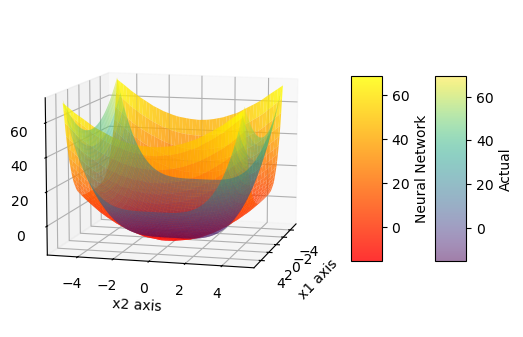

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Create data
x1_plot = np.linspace(-5, 5, 100)
x2_plot = np.linspace(-5, 5, 100)
x1_p, x2_p = np.meshgrid(x1_plot, x2_plot)

# Make actual function
z1 = y_func(x1_p, x2_p)
shape_z1 = np.shape(z1)
zNN = np.zeros(shape=(shape_z1))

# Approximate with NN
def evaluations(x1_test, x2_test, x1_mean, x1_std, x2_mean, x2_std, Y_max, Y_min):
  
  # Scale test inputs in the same way as training inputs
  x1test_scld = (x1_test - x1_mean) / x1_std
  x2test_scld = (x2_test - x2_mean) / x2_std
  x_test = torch.as_tensor([x1test_scld, x2test_scld], dtype=torch.float32)

  # Use NN model to determine the predicted output (Y scaled)
  model.eval()
  with torch.no_grad():
    y_pred = model(x_test)

  # Inverse the scaling that was done to Y for training
  y_inv = (y_pred.item() - 0.2)/0.6 * (Y_max - Y_min) + Y_min
  return y_inv

for i, x1  in enumerate(x1_plot):
  for j, x2 in enumerate(x2_plot):
    zNN[i,j] = evaluations(x1, x2, mean_x1, std_x1, mean_x2, std_x2, y_max, y_min)



# Create a figure and a 3D Axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot a 3D surface
surf1 = ax.plot_surface(x1_p, x2_p, z1, cmap='viridis', alpha=0.5)
surf2 = ax.plot_surface(x1_p, x2_p, zNN, cmap='autumn', alpha=0.8)

ax.view_init(elev=10, azim=15)  # Adjust the elevation and azimuth

# Labels and title
ax.set_xlabel('x1 axis')
ax.set_ylabel('x2 axis')
ax.set_zlabel('y axis')

fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=6, label='Actual')
fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=6, label='Neural Network')

# Show the plot
plt.show()

# Save neural network as ONNX function

In [15]:
import tempfile
import torch.onnx
from omlt.io.onnx import write_onnx_model_with_bounds, load_onnx_neural_network_with_bounds

# Create input bounds for x1 and x2
x1_min, x1_max = -5, 5
x2_min, x2_max = -5, 5 

# Scale input bounds
x1min_scld = (x1_min - mean_x1) / std_x1
x1max_scld = (x1_max - mean_x1) / std_x1
x2min_scld = (x2_min - mean_x2) / std_x2
x2max_scld = (x2_max - mean_x2) / std_x2
input_bounds_scld = [(x1min_scld, x1max_scld), (x2min_scld, x2max_scld)]

# Make random data for batch size, input size (dummy input to trace the model)
x_trace = torch.randn(200, 2, requires_grad=True)
with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    torch.onnx.export(
        model,
        x_trace,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    write_onnx_model_with_bounds(f.name, None, input_bounds_scld)
    print(f"Wrote PyTorch model to {f.name}")
    pytorch_model = f.name

Wrote PyTorch model to C:\Users\Jake\AppData\Local\Temp\tmpuir4om3r.onnx


# Import ONNX file and solve using Pyomo

In [16]:
import os
from omlt.neuralnet import FullSpaceNNFormulation
import pyomo.environ as pyo
from omlt.neuralnet.activations import ComplementarityReLUActivation
from omlt import OmltBlock

# Import NN from ONNX with specified bounds
network_pyo = load_onnx_neural_network_with_bounds(pytorch_model)
# Remove the temporary file created
os.remove(pytorch_model)

# Confirm layers and bounds
print(network_pyo.scaled_input_bounds)
for layer_id, layer in enumerate(network_pyo.layers):
    print(f"{layer_id}\t{layer}\t{layer.activation}")

# Initialize Pyomo model with x and y variables, default sense=minimize (correct here)
model_pyo = pyo.ConcreteModel()
model_pyo.x1 = pyo.Var(initialize = 0)
model_pyo.x2 = pyo.Var(initialize=0)
model_pyo.y = pyo.Var(initialize = 0)
model_pyo.obj = pyo.Objective(expr=(model_pyo.y))
model_pyo.nn = OmltBlock()

# Make mixed formulation to account for ReLU and sigmoid activation functions
formulation_mixed = FullSpaceNNFormulation(network_pyo,activation_constraints={
            "relu": ComplementarityReLUActivation()})
model_pyo.nn.build_formulation(formulation_mixed)

# Add constraint to link neural network inputs as x values in Pyomo model
@model_pyo.Constraint()
def connect_inputs_1(mdl):
    return mdl.x1 == mdl.nn.inputs[0]
@model_pyo.Constraint()
def connect_inputs_2(mdl):
    return mdl.x2 == mdl.nn.inputs[1]
# Add constraint to link neural network outputs as y value in Pyomo model
@model_pyo.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

# Select a solver and solve optimization problem using Pyomo
solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 1000
status = solver.solve(model_pyo, tee=True)
solution = (pyo.value(model_pyo.x1), pyo.value(model_pyo.x2), pyo.value(model_pyo.y))



{0: (-1.7310624744882732, 1.732353958830015), 1: (-1.7354817855833071, 1.728817562620259)}
0	InputLayer(input_size=[2], output_size=[2])	linear
1	DenseLayer(input_size=[2], output_size=[80])	relu
2	DenseLayer(input_size=[80], output_size=[80])	relu
3	DenseLayer(input_size=[80], output_size=[80])	relu
4	DenseLayer(input_size=[80], output_size=[1])	sigmoid
Ipopt 3.11.1: max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonz

AttributeError: 'ConcreteModel' object has no attribute 'outputs'

In [17]:
# Display solution results
print("Mixed NN Solution:")
print("# of variables: ",model_pyo.nvariables())
print("# of constraints: ",model_pyo.nconstraints())
print("x1 scld = ", solution[0])
print("x2 scld = ", solution[1])
print("y scld = ", solution[2])
print(f"Solve Time: {status['Solver'][0]['Time']}\n")

# Invert x1, x2, and y outputs from the solver
x1_opt = solution[0]*std_x1 + mean_x1
print("x1 = ", x1_opt)
x2_opt = solution[1]*std_x2 + mean_x2
print("x2 = ", x2_opt)
y_inv_opt = (solution[2] - 0.2)/0.6 * (y_max - y_min) + y_min
print(f'Model minimum: {y_inv_opt:.3f}')

# Compare to function evaluated at the solved x1 and x2 values
y_opt = y_func(x1_opt, x2_opt)
print(f'Function minimum: {y_opt:.3f}')

model_pyo.nn.inputs.pprint()
model_pyo.nn.outputs.pprint()




Mixed NN Solution:
# of variables:  733
# of constraints:  971
x1 scld =  -0.0809538647861789
x2 scld =  0.18701480521562805
y scld =  0.19949118762533857
Solve Time: 4.857123851776123

x1 =  -0.2356043765689173
x2 =  0.5494528548633003
Model minimum: -15.074
Function minimum: -14.935
inputs : Size=2, Index=nn.inputs_set
    Key : Lower               : Value               : Upper             : Fixed : Stale : Domain
      0 : -1.7310624744882732 : -0.0809538647861789 : 1.732353958830015 : False : False :  Reals
      1 : -1.7354817855833071 : 0.18701480521562805 : 1.728817562620259 : False : False :  Reals
outputs : Size=1, Index=nn.outputs_set
    Key : Lower : Value               : Upper : Fixed : Stale : Domain
      0 :  None : 0.19949118762533857 :  None : False : False :  Reals
3 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :  None : -0.0809538647861789 :  None : False : False :  Reals
    x2

# Display results using heat map

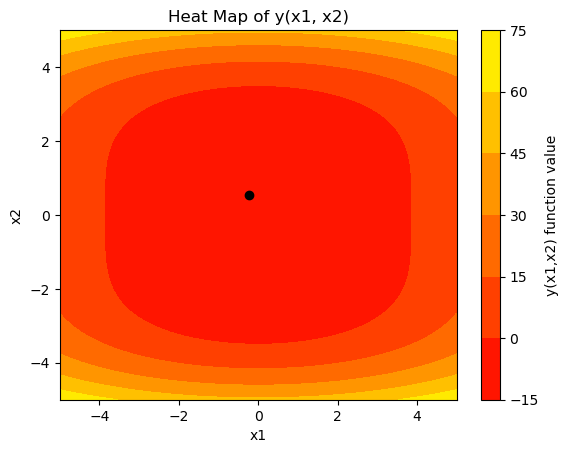

In [11]:
import numpy as np

x1_map = np.linspace(-5, 5, 100)
x2_map = x1_map

# Create meshgrid
x1_grid, x2_grid = np.meshgrid(x1_map, x2_map)

# Compute y values for the grid
y_grid = y_func(x1_grid, x2_grid)


import matplotlib.pyplot as plt
plt.figure()
contour = plt.contourf(x1_grid, x2_grid, y_grid, cmap='autumn')
plt.scatter(x1_opt, x2_opt, color='black', label='Model Solution')
colorbar =plt.colorbar(contour, label='y(x1,x2) function value')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Heat Map of y(x1, x2)')
plt.show()